### ¡Danger Zone! Cartopy version does not match Fiona!  Gross!

In [2]:
%matplotlib inline
import geopandas as gpd
import pysal as ps

In [3]:
geo_df = gpd.read_file("data/cb_2015_us_state_20m.shp")
geo_df.set_index(geo_df["STATEFP"].astype(int), inplace = True)

In [4]:
continental =  (geo_df.index < 57)
continental &= (geo_df.index != 15)
continental &= (geo_df.index != 2)
geo_df = geo_df[continental]

In [5]:
import requests, pandas as pd
j = requests.get("http://api.census.gov/data/2014/acs5/profile?for=state:*&get=DP02_0037PE").json()
smom_df = pd.DataFrame(j[1:], columns = j[0])
smom_df["state"] = smom_df["state"].astype(int)
smom_df.set_index("state", inplace = True)
smom_df["DP02_0037PE"] = smom_df["DP02_0037PE"].astype(float)
smom_df.rename(columns = {"DP02_0037PE" : "Percent Mothers Unmarried"}, inplace = True)

merged = geo_df.join(smom_df, how = "inner")

In [27]:
import matplotlib.pyplot as plt
from cartopy import crs

from matplotlib.colors import Normalize

ft = "Percent Mothers Unmarried"
albers = merged.to_crs(epsg=2163)

norm = Normalize(vmin = albers[ft].min(), vmax = albers[ft].max())
cmap = plt.cm.ScalarMappable(norm=norm, cmap="RdBu")
    
subplot_kw = dict(projection = crs.epsg(2163))
fig, ax = plt.subplots(figsize=(5, 5), subplot_kw=subplot_kw)

ax.set_extent([-122, -73, 25, 50], crs = crs.PlateCarree())

for ix, rec in albers.iterrows():
    
    try:    iter(rec['geometry'])
    except: geom = (rec['geometry'],)
    else:   geom = rec['geometry']

    color = cmap.to_rgba(rec[ft])
    ax.add_geometries(geom, crs = crs.epsg(2163), facecolor = color, alpha = 1.0, 
                      edgecolor = "black", linewidth = 0.5)

ax.background_patch.set_visible(False)
ax.outline_patch.set_visible(False)
    
fig = ax.get_figure()
cax = fig.add_axes([0.17, 0.23, 0.65, 0.01])
sm = plt.cm.ScalarMappable(cmap='RdBu', norm=norm)
sm._A = [] # gross
fig.colorbar(sm, cax = cax, label = "Single Mothers [%]", orientation='horizontal')
fig.savefig('choropleth.png', dpi=300, transparent=True, bbox_inches = "tight", pad_inches=0.2)
plt.close(fig)

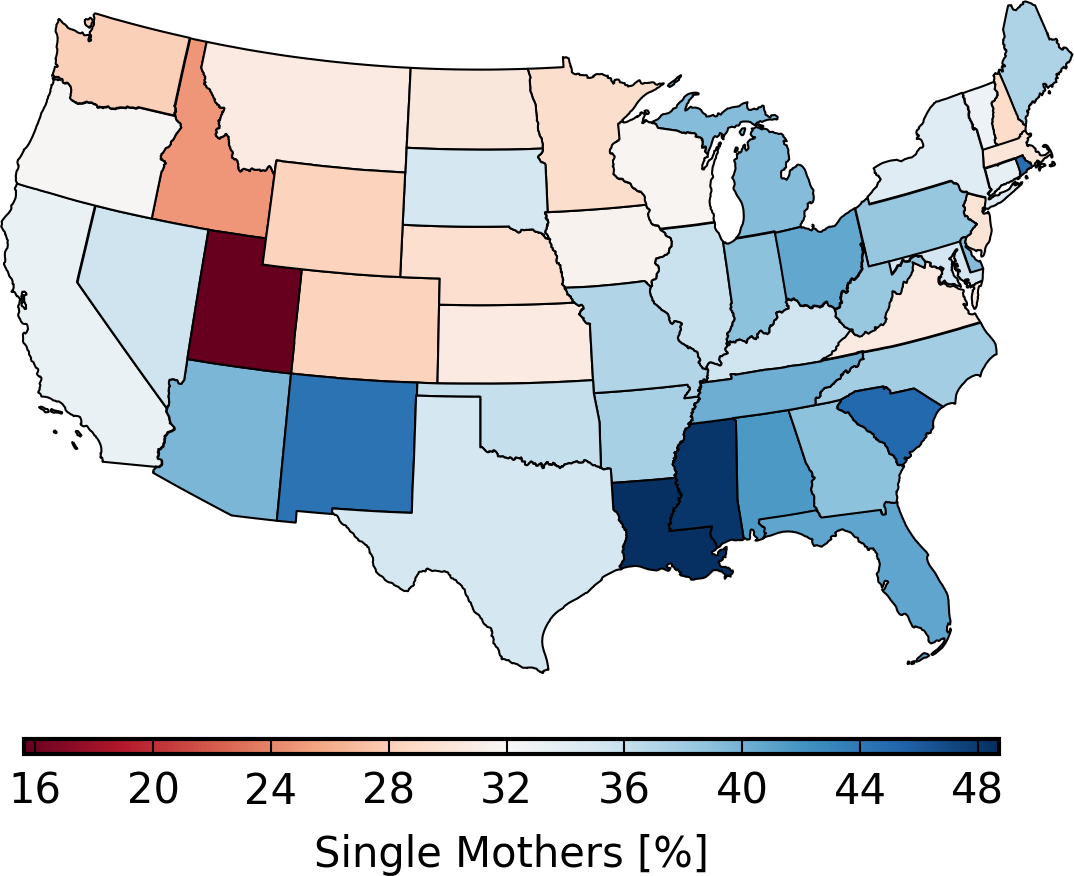

In [28]:
from anatools import trim
img = trim('choropleth.png', "us_single_mothers.png")
img

### A messier but more-powerful alternative. 

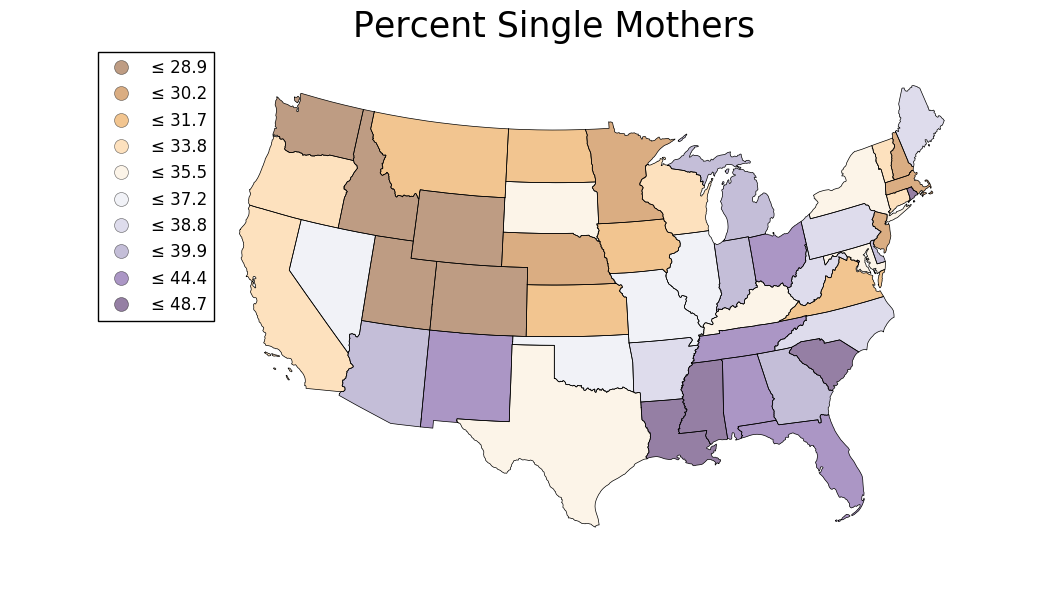

In [58]:
import pysal as ps
import pandas as pd
import matplotlib.pyplot as plt

ft, bins = "Percent Mothers Unmarried", 10

q = ps.Quantiles(merged[ft], k = bins)
labels = ["≤ {:.1f}".format(q.bins[i], i + 9) for i in range(bins) ]

merged["qyb"] = q.yb
merged["fg_" + ft] = pd.Series(merged["qyb"], dtype="category")
merged["fg_" + ft].cat.rename_categories(labels, inplace = True)

ax = merged.to_crs(epsg=2163).assign(cl = q.yb).plot(column = "fg_" + ft, categorical = True, figsize = (12, 12), 
                                   linewidth = 0.5, cmap = "PuOr", legend = True)

ax.set_title("Percent Single Mothers", fontsize = 25)
ax.set_axis_off()

### Not more advanced, just different.

In [6]:
import pysal as ps
import folium
import matplotlib.pyplot as plt

m = folium.Map([39.828175, -98.5795], 
               tiles='cartodbpositron', 
               zoom_start = 4, min_zoom = 4)

# with open('census.geojson', 'w') as f: f.write(merged.to_json())

ft = "Percent Mothers Unmarried"
threshold_scale = list(ps.esda.mapclassify.Quantiles(merged[ft], k = 5).bins)
threshold_scale = [merged[ft].min()] + threshold_scale[:-1] + [0.1 + merged[ft].max()]

m.choropleth(geo_path = "census.geojson", 
             data = merged, 
             columns = ['GEOID', 'Percent Mothers Unmarried'],
             threshold_scale = threshold_scale,
             key_on='feature.properties.GEOID',
             fill_opacity = 0.7, line_opacity=0.5,
             fill_color = 'YlGn',
             legend_name='Percent Single Mothers')

m.save("us.html")
m

### Pennsylania Election Returns

In [55]:
import requests, json
resp = requests.get("http://www.electionreturns.pa.gov/ENR_New/api/ElectionReturn/GetCountyBreak?officeId=1&districtId=1&methodName=GetCountyBreak&electionid=undefined&electiontype=undefined&isactive=undefined")
j = json.loads(resp.text.replace("\\\"", "\"")[1:-1])

In [57]:
with open("pa_demshare.csv", "w") as out:
    out.write("county,demfrac2\n")
    for name, candidates in j["Election"]["Statewide"][0].items():
        demvotes = sum(int(c["Votes"]) for c in candidates if c["PartyName"] == "DEM")
        repvotes = sum(int(c["Votes"]) for c in candidates if c["PartyName"] == "REP")
        dem2frac = demvotes / (demvotes + repvotes)

        out.write("{},{:.4f} \n".format(name.lower(), dem2frac))